In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import normflows as nf
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from tqdm import tqdm
import random
from torch.utils.data import DataLoader
import pandas as pd
import openturns as ot
print(f"Using device: {device}")
import pyvinecopulib as pv
from scipy.stats import gaussian_kde
from scipy.stats import gamma
from scipy.stats import expon
from scipy.stats import norm
from GPDFlow import DataTransform
from GPDFlow import T_mGPD_NF

/home/pgrad2/2448355h/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


Using device: cuda


In [42]:
def sim_revexp_u_mgpd(a, n, d, beta, sig, gamma, MGPD=True, std=False):
    lam = np.exp(beta)
    Y = np.zeros((n, d))
    C = 1 / np.min(lam)
    k = 0

    while k < n:
        U = np.random.uniform(0, 1, d)
        W = (U ** a) / lam
        R = np.random.uniform(0, C)
        
        Ind = R < np.max(W)
        
        if Ind:
            Y[k, :] = W / R
            k += 1

    if std and not MGPD:
        return np.log(Y)

    X = []
    for j in range(d):
        if gamma[j] != 0:
            X.append(sig[j] * (Y[:, j] ** gamma[j] - 1) / gamma[j])
        else:
            X.append(sig[j] * np.log(Y[:, j]))
    X = np.column_stack(X)

    if MGPD and not std:
        return X
    if std and MGPD:
        return {'X': X, 'Z': np.log(Y)}

In [69]:
dir_out = "/home/pgrad2/2448355h/My_PhD_Project/01_Output/GPDFlow/"

dim = 2
base = nf.distributions.DiagGaussian(dim)
# base = my_DiagGaussian(dim)

#####################################Real NVP############################
num_layers = 16
torch.manual_seed(0)

# latent_size = dim
# b = torch.Tensor([1 if i % 2 == 0 else 0 for i in range(latent_size)])
# flows = []
# for i in range(num_layers):
#     s = nf.nets.MLP([latent_size, 8 * latent_size,   latent_size], init_zeros=True, output_fn='tanh')
#     t = nf.nets.MLP([latent_size, 8 * latent_size,   latent_size], init_zeros=True, output_fn='tanh')
#     if i % 2 == 0:
#         flows += [nf.flows.MaskedAffineFlow(b, t, s)]
#     else:
#         flows += [nf.flows.MaskedAffineFlow(1 - b, t, s)]
#     flows += [nf.flows.ActNorm(latent_size)]

# f_T_model = nf.NormalizingFlow(base, flows)
# f_T_model = f_T_model.to(device)

num_layers = 4
latent_size = 2
hidden_units = 20
hidden_layers = 2
context_size = 4

flows = []
for i in range(num_layers):
    flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units, 
                                                             num_context_channels=context_size)]
    flows += [nf.flows.LULinearPermute(latent_size)]

f_T_model = nf.ConditionalNormalizingFlow(base, flows)
f_T_model = f_T_model.to(device)



batch_size = 128
loss_history = []
epochs = 50

model = T_mGPD_NF(dim=dim, flow =f_T_model, device=device, s_min=-10,
                  s_max = 10, num_integration_points=1000, penalty_lambda=10000,fix_margin=True)

optimizer = torch.optim.Adam([
    {'params': model.flow_model.parameters(), 'lr': 1e-3},  # Flow layers
    {'params': model.data_transform.log_sigma, 'lr': 1e-2},  # Faster for log_sigma
    {'params': model.data_transform.theta, 'lr': 1e-2}       # Faster for gamma
], weight_decay = 1e-5 )

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

In [73]:
f_T_model.forward_kld?

Signature: f_T_model.forward_kld(x, context=None)
Docstring:
Estimates forward KL divergence, see [arXiv 1912.02762](https://arxiv.org/abs/1912.02762)

Args:
  x: Batch sampled from target distribution
  context: Batch of conditions/context

Returns:
  Estimate of forward KL divergence averaged over batch
File:      ~/.local/lib/python3.10/site-packages/normflows/core.py
Type:      method


In [70]:
n_param = 0
for param in model.parameters():
    n_param += len(param)
print(n_param)

1674


In [54]:


seed = 1234
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # for multi-GPU setups
    
d = 2
# a = np.array([3,0.5,1, 5,2,  3,0.5,1, 5,2 ]*2 + [3,0.5,1, 5,2])

n_samples = 1000
covariates = np.stack([np.random.normal(loc=1, scale=1, size=n_samples),
                       np.random.normal(loc=2, scale=1, size=n_samples),
                       np.random.normal(loc=0, scale=1, size=n_samples),
                       np.random.normal(loc=-1, scale=1, size=n_samples)],axis=1)
a1 = np.sin(covariates[:,0]) + 0.5*covariates[:,1] - 5*covariates[:,2] +0.01*covariates[:,3]**2
a1 = 5/(1 + np.exp(-a1))

a2 = 6- a1
a = np.stack([a1,a2], axis=1)


beta = np.array([0]*d)
# sig = np.array([0.3,3,0.1,0.2,1.5,  0.3,3,0.1,0.2,1.5]*2 + [0.3,3,0.1,0.2,1.5])
# gamma = np.array([-0.1, 0.2, 0, -0.05, 0.1,  -0.1, 0.2, 0, -0.05, 0.1]*2 + [-0.1, 0.2, 0, -0.05, 0.1])
sig = np.array([1]*d)
gamma = np.array([0]*d)


samples = np.apply_along_axis(sim_revexp_u_mgpd, axis=1, arr=a, n= 1,d=2,beta=beta,sig=sig,gamma=gamma)
samples = samples.reshape(n_samples,dim)

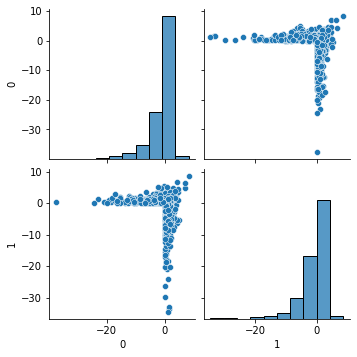

In [51]:
sns.pairplot(pd.DataFrame(samples),diag_kws={'bins': 10})

0.000113152


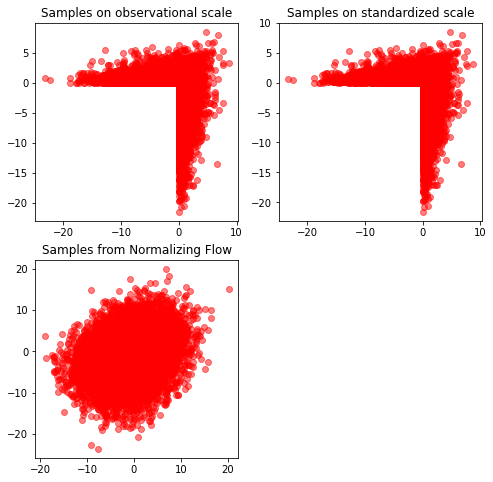

Done Epoch 0
Done Epoch 1
Done Epoch 2
Done Epoch 3
Done Epoch 4
Done Epoch 5
Done Epoch 6
Done Epoch 7
Done Epoch 8
Done Epoch 9


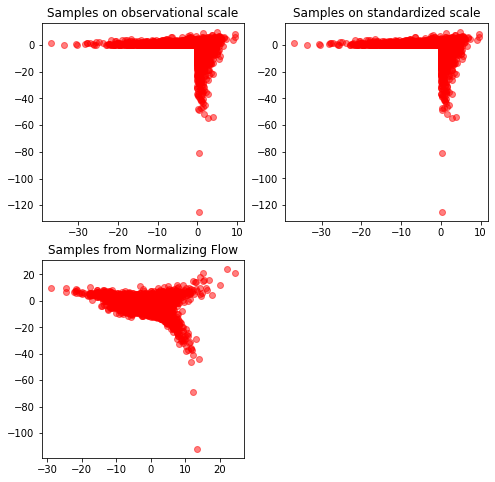

Done Epoch 10
Done Epoch 11
Done Epoch 12
Done Epoch 13
Done Epoch 14
Done Epoch 15
Done Epoch 16
Done Epoch 17
Done Epoch 18
Done Epoch 19


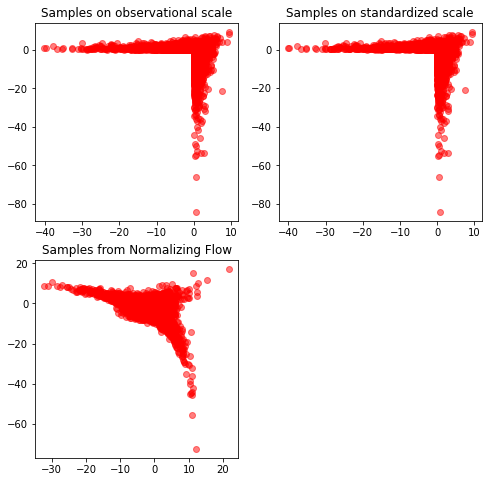

Done Epoch 20
Done Epoch 21
Done Epoch 22
Done Epoch 23
Done Epoch 24
Done Epoch 25
Done Epoch 26
Done Epoch 27
Done Epoch 28
Done Epoch 29


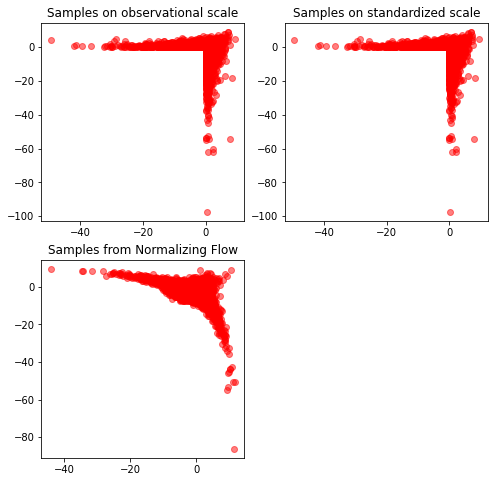

Done Epoch 30
Done Epoch 31
Done Epoch 32
Done Epoch 33
Done Epoch 34
Done Epoch 35
Done Epoch 36
Done Epoch 37
Done Epoch 38
Done Epoch 39


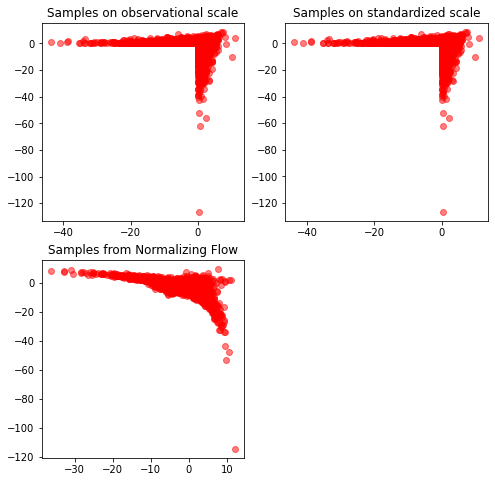

Done Epoch 40
Done Epoch 41
Done Epoch 42
Done Epoch 43
Done Epoch 44
Done Epoch 45
Done Epoch 46
Done Epoch 47
Done Epoch 48
Done Epoch 49


Text(0.5, 1.0, 'Training Loss')

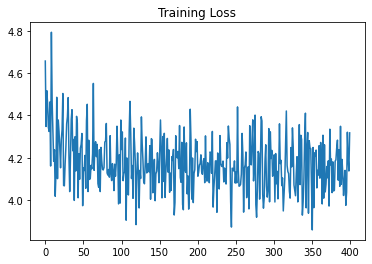

In [55]:

data = torch.tensor(samples, dtype=torch.float, device = device)

memory = torch.cuda.memory_allocated(device) /10**9
print(memory)

Training_Data = DataLoader(data, batch_size=batch_size, shuffle=True)
torch.autograd.set_detect_anomaly(True)

for epoch in range(epochs):
    epoch_loss = 0.0
    
    for x_data in Training_Data:
        # Sample a batch of data from h_U

        batch_loss = model(x_data)

        # Backpropagation
        optimizer.zero_grad()
        batch_loss.backward()

        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()

        # Record loss
        loss_history.append(batch_loss.item())
        epoch_loss += batch_loss.item()

        if torch.isnan(batch_loss) or torch.isinf(batch_loss):
            print("NaN or Inf detected!")
            break
    if epoch%10 == 0:
        samples_obs, samples_std, samples_T= model.sample(10000)
        plt.figure(figsize=(8,8))
        plt.subplot(2, 2, 1)
        plt.scatter(samples_obs[:,0].cpu().data.numpy(), samples_obs[:,1].cpu().data.numpy(), alpha=0.5, color='red')
        plt.title('Samples on observational scale')
        plt.subplot(2, 2, 2)
        plt.scatter(samples_std[:,0].cpu().data.numpy(), samples_std[:,1].cpu().data.numpy(), alpha=0.5, color='red')
        plt.title('Samples on standardized scale')
        plt.subplot(2, 2, 3)
        plt.scatter(samples_T[:,0].cpu().data.numpy(), samples_T[:,1].cpu().data.numpy(), alpha=0.5, color='red')
        plt.title('Samples from Normalizing Flow')
        plt.show()

    # Debugging: Print shapes

    scheduler.step()
    print(f'Done Epoch {epoch}')

plt.plot(loss_history)
plt.title('Training Loss')

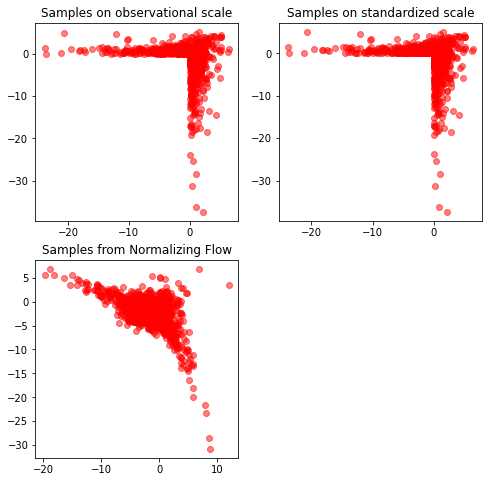

In [63]:
samples_obs, samples_std, samples_T= model.sample(1000)
plt.figure(figsize=(8,8))
plt.subplot(2, 2, 1)
plt.scatter(samples_obs[:,0].cpu().data.numpy(), samples_obs[:,1].cpu().data.numpy(), alpha=0.5, color='red')
plt.title('Samples on observational scale')
plt.subplot(2, 2, 2)
plt.scatter(samples_std[:,0].cpu().data.numpy(), samples_std[:,1].cpu().data.numpy(), alpha=0.5, color='red')
plt.title('Samples on standardized scale')
plt.subplot(2, 2, 3)
plt.scatter(samples_T[:,0].cpu().data.numpy(), samples_T[:,1].cpu().data.numpy(), alpha=0.5, color='red')
plt.title('Samples from Normalizing Flow')
plt.show()

In [ ]:
def empirical_conditional_tail_dependence(X, p, cond = 'and'):

    # Compute the quantiles
    quantile = np.quantile(X, p, axis = 0)
    
    # Count joint exceedances
    joint_exceedance = X[:,0] > quantile[0]
    if cond == 'and':
        for j in range(1,X.shape[1]):
            joint_exceedance &= X[:,j] > quantile[j]
    else:
        for j in range(1,X.shape[1]):
            joint_exceedance |= X[:,j] > quantile[j]
        
    exceedance_X1 = np.sum(X[:,0] > quantile[0])
    joint_exceedance = np.sum(joint_exceedance)
    # Calculate lambda_u
    if exceedance_X1 == 0:  # Avoid division by zero
        return 0.0
    chi_u = joint_exceedance / exceedance_X1
    return chi_u
probs = np.linspace(0.50, 0.99, 100)

plt.figure(figsize=(8,8))
plt.subplot(2, 2, 1)
chi_emp = [empirical_conditional_tail_dependence(samples, p, 'and') for p in probs]
chi_est = [empirical_conditional_tail_dependence(samples_obs.cpu().data.numpy(), p, 'and') for p in probs]
ax = sns.lineplot(x=probs, y=chi_emp, label='Empirical', color='darkorange', linewidth=2)
ax = sns.lineplot(x=probs, y=chi_est, label='Fitted', color='cornflowerblue', linewidth=2)

plt.subplot(2, 2, 2)
chi_emp = [empirical_conditional_tail_dependence(samples, p, 'or') for p in probs]
chi_est = [empirical_conditional_tail_dependence(samples_obs.cpu().data.numpy(), p, 'or') for p in probs]
ax1 = sns.lineplot(x=probs, y=chi_emp, label='Empirical', color='darkorange', linewidth=2)
ax1 = sns.lineplot(x=probs, y=chi_est, label='Fitted', color='cornflowerblue', linewidth=2)

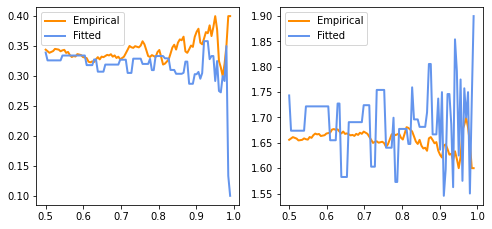

In [ ]:
probs = np.linspace(0.50, 0.99, 100)

plt.figure(figsize=(8,8))
plt.subplot(2, 2, 1)
chi_emp = [empirical_conditional_tail_dependence(samples, p, 'and') for p in probs]
chi_est = [empirical_conditional_tail_dependence(samples_obs.cpu().data.numpy(), p, 'and') for p in probs]
ax = sns.lineplot(x=probs, y=chi_emp, label='Empirical', color='darkorange', linewidth=2)
ax = sns.lineplot(x=probs, y=chi_est, label='Fitted', color='cornflowerblue', linewidth=2)

plt.subplot(2, 2, 2)
chi_emp = [empirical_conditional_tail_dependence(samples, p, 'or') for p in probs]
chi_est = [empirical_conditional_tail_dependence(samples_obs.cpu().data.numpy(), p, 'or') for p in probs]
ax1 = sns.lineplot(x=probs, y=chi_emp, label='Empirical', color='darkorange', linewidth=2)
ax1 = sns.lineplot(x=probs, y=chi_est, label='Fitted', color='cornflowerblue', linewidth=2)

In [62]:
samples_obs.cpu().data.numpy().shape


(10000, 2)

In [7]:
torch.cuda.memory_allocated(device) /10**9

0.645720576